# Import Libraries

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [3]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [4]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Visualization

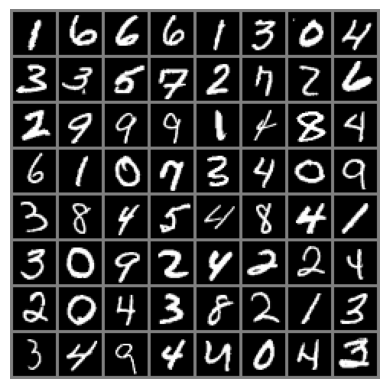

In [5]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.show()

imshow(make_grid(images, nrow=8))

# Maxout Network

In [6]:
class Maxout(nn.Module):
    def __init__(self, din, dout, k):
        super(Maxout, self).__init__()
        self.din = din
        self.dout = dout
        self.k = k
        self.linear = nn.Linear(din, k * dout)

    def forward(self, x):
        linear_output = self.linear(x)
        reshaped_output = linear_output.view(x.size(0), self.dout, self.k)
        max_output = torch.max(reshaped_output, dim=2).values
        return max_output

In [7]:
class MaxoutNetwork(nn.Module):
    def __init__(self, k=4, input_size=784, hidden_size=1200, num_classes=10):
        super(MaxoutNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            Maxout(input_size, hidden_size, k),
            nn.Dropout(0.4),
            Maxout(hidden_size, num_classes, k),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
torch.cuda.empty_cache()

In [9]:
model = MaxoutNetwork()
model.to(device)

MaxoutNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.4, inplace=False)
    (2): Maxout(
      (linear): Linear(in_features=784, out_features=4800, bias=True)
    )
    (3): Dropout(p=0.4, inplace=False)
    (4): Maxout(
      (linear): Linear(in_features=1200, out_features=40, bias=True)
    )
    (5): LogSoftmax(dim=-1)
  )
)

# Train

In [10]:
criterion = nn.NLLLoss()

In [11]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-6)

In [12]:
epochs = 50

In [13]:
losses = []

In [14]:
for epoch in range(epochs):
    total_losss = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if batch_idx % 600 == 0:
            print(f"[Epoch {epoch + 1}/{epochs}] - [Loss: {np.mean(losses):.3f}]")

[Epoch 1/50] - [Loss: 2.338]
[Epoch 1/50] - [Loss: 0.598]
[Epoch 2/50] - [Loss: 0.537]
[Epoch 2/50] - [Loss: 0.485]
[Epoch 3/50] - [Loss: 0.466]
[Epoch 3/50] - [Loss: 0.443]
[Epoch 4/50] - [Loss: 0.436]
[Epoch 4/50] - [Loss: 0.420]
[Epoch 5/50] - [Loss: 0.417]
[Epoch 5/50] - [Loss: 0.412]
[Epoch 6/50] - [Loss: 0.410]
[Epoch 6/50] - [Loss: 0.404]
[Epoch 7/50] - [Loss: 0.404]
[Epoch 7/50] - [Loss: 0.401]
[Epoch 8/50] - [Loss: 0.400]
[Epoch 8/50] - [Loss: 0.397]
[Epoch 9/50] - [Loss: 0.397]
[Epoch 9/50] - [Loss: 0.393]
[Epoch 10/50] - [Loss: 0.394]
[Epoch 10/50] - [Loss: 0.392]
[Epoch 11/50] - [Loss: 0.392]
[Epoch 11/50] - [Loss: 0.392]
[Epoch 12/50] - [Loss: 0.392]
[Epoch 12/50] - [Loss: 0.391]
[Epoch 13/50] - [Loss: 0.390]
[Epoch 13/50] - [Loss: 0.390]
[Epoch 14/50] - [Loss: 0.390]
[Epoch 14/50] - [Loss: 0.390]
[Epoch 15/50] - [Loss: 0.390]
[Epoch 15/50] - [Loss: 0.389]
[Epoch 16/50] - [Loss: 0.389]
[Epoch 16/50] - [Loss: 0.390]
[Epoch 17/50] - [Loss: 0.390]
[Epoch 17/50] - [Loss: 0.391

# Test

In [26]:
correct_pred = {str(k): 0 for k in range(10)}
total_pred = {str(k): 0 for k in range(10)}

In [27]:
with torch.no_grad():
    model.eval()

    for data in test_dataloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[str(label.item())] += 1

            total_pred[str(label.item())] += 1

In [28]:
for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[class_name]
    print(f"Accuracy for class: {class_name} is {accuracy:.2f}%")

Accuracy for class: 0 is 99.90%
Accuracy for class: 1 is 99.47%
Accuracy for class: 2 is 95.64%
Accuracy for class: 3 is 98.91%
Accuracy for class: 4 is 98.37%
Accuracy for class: 5 is 96.30%
Accuracy for class: 6 is 97.60%
Accuracy for class: 7 is 97.18%
Accuracy for class: 8 is 94.87%
Accuracy for class: 9 is 95.34%


In [29]:
total_accuracy = 100 * float(np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values())))
print(f'Total Accuracy: {total_accuracy:.2f} %')

Total Accuracy: 97.39 %
